# Custom Dataset for 3D CNN

In [1]:
!pip install tensorflow_docs
!pip install mediapipe
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 51.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
import os
import pickle
import mediapipe as mp
from google.colab.patches import cv2_imshow
import uuid
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision

import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import random

In [4]:
annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DATAFRAME.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
video_dir = "/content/drive/MyDrive/slovo/slovo" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo"
train_path = "/content/drive/MyDrive/slovo/datasets/train"
test_path = "/content/drive/MyDrive/slovo/datasets/test"
IMG_SIZE = 224

In [33]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<19,'train', 'test')
video_labels = video_labels[video_labels.text.isin(["слон", "пингвин"])].tail(10)
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
15391,d7daaee6-284b-47bd-a304-e43df5d5eb01,пингвин,0a11105fbfa6d452b86187db53b753e2,636,360,96.0,11,67,18,train
15394,1d269e1e-f359-423c-b7ba-3aa42ed3444d,слон,012015303772a32f4d91adec2929cbae,640,360,112.0,35,97,19,test
15412,6bd6120e-9896-48db-afb6-9e01713c6f25,слон,0a11105fbfa6d452b86187db53b753e2,636,360,107.0,9,84,20,test
15419,e61c12a9-f727-441d-86e8-a9b854decd3e,пингвин,3018b64d2c938f5b6a0826dfdf486f2c,640,360,165.0,32,111,19,test
15445,2eca9c1e-103c-4a23-98c8-1e994fe76762,пингвин,e0ca58d03fc73a305046edcdf7ef7492,360,640,109.0,18,65,20,test


In [9]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 2. Example classes: ('пингвин', 'слон')


In [10]:
classes.index('слон')

1

In [16]:
for i in video_labels[video_labels.dataset=='test'].index:
  print(i)

15394
15412
15419
15445


In [18]:
mp_face = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

In [143]:
class VideoDataset(Dataset):
    def __init__(self, video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "test"):
        super(VideoDataset, self).__init__()
        self.video_labels = video_labels
        self.video_dir = video_dir
        self.IMG_SIZE = IMG_SIZE
        self.min_frame_count = min_frame_count
        self.video_data=[]
        self.video_label=[]
        for i in video_labels[video_labels.dataset==ds_type].index:
          frames, label = self.get_video_and_label(i)
          if frames is not None:  # В некоторых видео не может определить лицо mimetype?
              self.video_data.append(frames)
              self.video_label.append(classes.index(label))


    def __len__(self):
        return len(self.video_label)

    def crop_center_square(self, image, min_y, max_y, min_x, max_x):
        image = image[min_y : max_y, min_x : max_x]
        new_size = max(image.shape[0], image.shape[1])
        blank_image = np.zeros((new_size,new_size,3), np.uint8)
        blank_image[0 : image.shape[0], 0 : image.shape[1]] = image
        blank_image = cv2.resize(blank_image, (self.IMG_SIZE, self.IMG_SIZE))
        return blank_image

    def crop_coordinates(self, image):
      shape = image.shape
      with mp_face.FaceMesh(static_image_mode=True,
                                              max_num_faces=1,
                                              refine_landmarks=True,
                                              min_detection_confidence=0.5) as face_mesh:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        has_result = False
        i=0
        while not has_result:
          results = face_mesh.process(image)
          i+=1
          if i==5 or results.multi_face_landmarks is not None:
            has_result = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image.flags.writeable = True
        if results.multi_face_landmarks is None:
          return None
        face_ls = results.multi_face_landmarks[0].landmark
        y_coordinates = [idx.y for idx in face_ls]
        x_coordinates = [idx.x for idx in face_ls]
        max_y, min_y = max(y_coordinates), min(y_coordinates)
        max_x, min_x = max(x_coordinates), min(x_coordinates)
        middle_x = (min_x + (max_x-min_x)/2) * shape[1]
        delta = max_y-min_y
        max_y, min_y = min(int((max_y+3*delta)*shape[0]),shape[0]), max(int((min_y-delta)*shape[0]),0)
        height = max_y - min_y
        max_x, min_x = min(int(max_x*shape[1]) + height//2, shape[1]) , max(int(min_x*shape[1]) - height//2,0)
      return min_y, max_y, min_x, max_x

    def load_video(self, path, begin, end, max_frames=0, label=None):
        cap = cv2.VideoCapture(path)
        frames = []
        gray_frames = []
        min_y, max_y, min_x, max_x = 0, 0, 0, 0
        frame_index=begin+1
        tries = 5
        for i in range(tries):
            try:
                while True and frame_index <= end:
                    with mp_face.FaceMesh(static_image_mode=True,
                                            max_num_faces=1,
                                            refine_landmarks=True,
                                            min_detection_confidence=0.5) as face_mesh:
                        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                        ret, frame = cap.read()
                        if not ret:
                            break
                        if frame_index==begin+1:
                          cc = self.crop_coordinates(frame)
                          if cc is None:
                            begin+=1
                          else:
                            min_y, max_y, min_x, max_x = cc
                        if (min_y, max_y, min_x, max_x) != (0, 0, 0, 0):
                            frame = self.crop_center_square(frame, min_y, max_y, min_x, max_x)
                            frames.append(frame)
                            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                            gray_frames.append(gray_frame)
                    frame_index+=1
                    if len(frames) == max_frames:
                        break
            except:
                if i < tries - 1: # i is zero indexed
                    continue
            if len(frames) > 0:
                break

        cap.release()
        if len(gray_frames)==0:
          print(f"No frames extracted from: {path}")
          return None
        totalt_frame_cnt = len(gray_frames)
        if totalt_frame_cnt < self.min_frame_count:
          all_idxs = list(range(totalt_frame_cnt))
          add_idxs = random.choices(range(totalt_frame_cnt), k=self.min_frame_count-totalt_frame_cnt)
          all_idxs.extend(add_idxs)
        else:
          all_idxs = random.sample(range(totalt_frame_cnt), k=self.min_frame_count)
        gray_frames = [gray_frames[i] for i in sorted(all_idxs)]
        return torch.from_numpy(np.array(gray_frames))

    def get_video_and_label(self, idx):
        filename  = os.path.join(self.video_dir, self.video_labels[self.video_labels.index==idx]['attachment_id'][idx]+".mp4")
        label = self.video_labels[self.video_labels.index==idx]['text'][idx]
        begin = self.video_labels[self.video_labels.index==idx]['begin'][idx]
        end = self.video_labels[self.video_labels.index==idx]['end'][idx]
        frames = self.load_video(filename, begin, end, label=label) # Загрузка видео!!!!
        return frames, label

    def __getitem__(self, index):
        frames= self.video_data[index]
        label=self.video_label[index]
        frames=torch.Tensor(frames)
        #frames=frames.permute(3,0,1,2)
        # for frame in frames:
        #     frame.div_(127.5).sub_(1)
        return frames, label

* The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).
* The __len__ function returns the number of samples in our dataset.
* The __getitem__ function loads and returns a sample from the dataset at the given index idx.

In [112]:
video_labels[video_labels.index==15445]['text'][15445]

'пингвин'

In [144]:
use_cuda = False
min_frame_count = 25
train_batch_size=1
test_batch_size=1

train_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
test_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

train_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "train"), batch_size=train_batch_size, shuffle=True, **train_kwargs)
test_dataloader = DataLoader(VideoDataset(video_labels, video_dir, IMG_SIZE, min_frame_count, ds_type = "test"), batch_size=test_batch_size, shuffle=True, **test_kwargs)

No frames extracted from: /content/drive/MyDrive/slovo/slovo/40ed1244-1c22-4efb-bac4-490f510078c9.mp4
No frames extracted from: /content/drive/MyDrive/slovo/slovo/2eca9c1e-103c-4a23-98c8-1e994fe76762.mp4


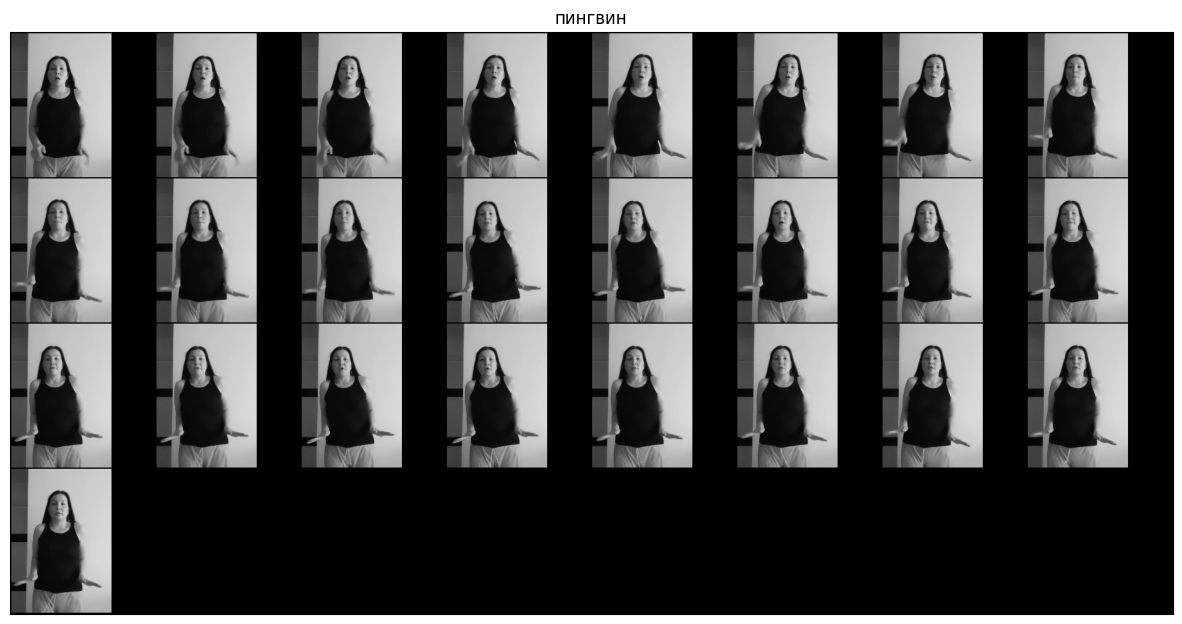

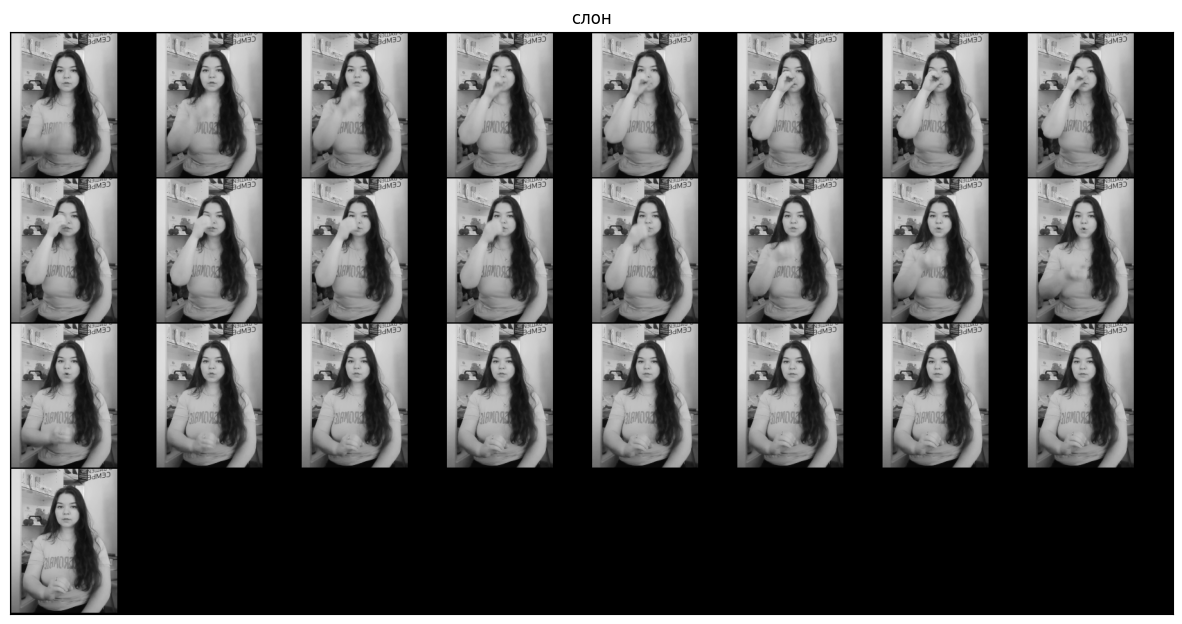

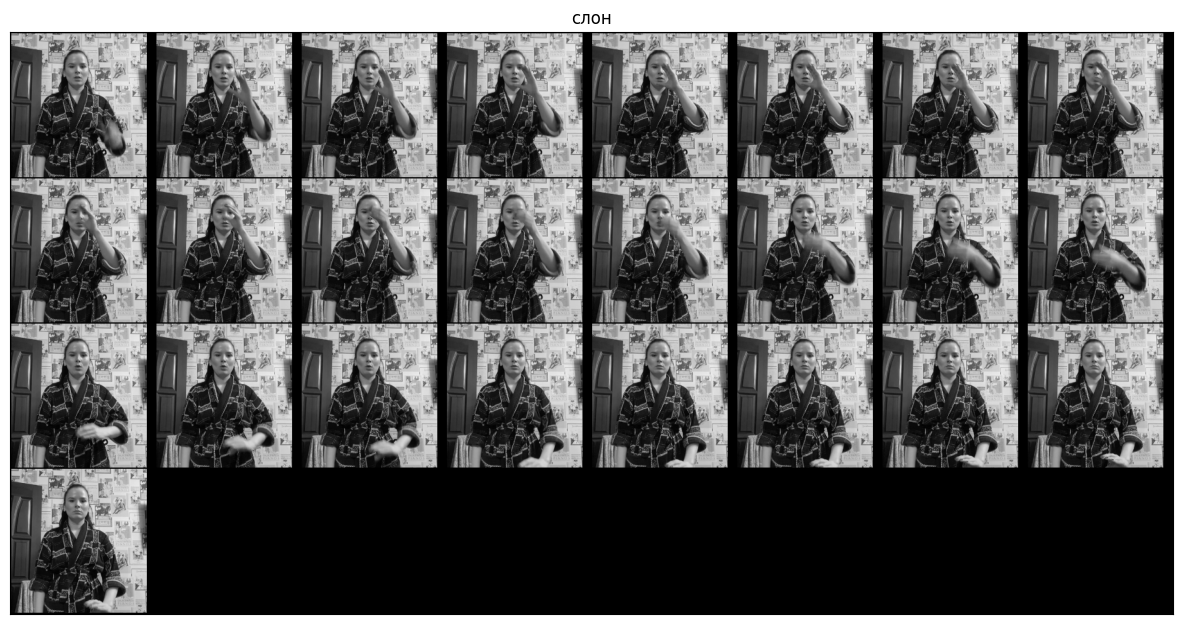

In [151]:
def show(imgs, label):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
    plt.title(label)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



test_dl = iter(test_dataloader)
for i in range(3):
  frames, labels = next(test_dl)
  frames = frames.permute(1,0, 2,3)
  show(torchvision.utils.make_grid(frames), classes[labels.item()])
